In [71]:
"""
Congressional Trading Strategy - Jupyter Notebook Implementation
Fixed version with proper debugging and computation
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Import project modules
import load_trades
from data_utils import formatted_invested_amount_dict

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

In [72]:
def load_congressional_data():
    """Load and prepare congressional trading data with debugging"""
    print("Loading congressional trading data...")
    
    # Load from the processed all_purchases file instead of reprocessing all PDFs
    try:
        # Try to load the processed all_purchases file first
        all_purchases_path = 'stock_purchases/all_purchases'
        if os.path.exists(all_purchases_path):
            print("Loading from processed all_purchases file...")
            trades_with_tickers = pd.read_csv(all_purchases_path)
        else:
            print("all_purchases file not found, processing PDFs...")
            # Fallback to processing PDFs if all_purchases doesn't exist
            all_trades = load_trades.get_and_format_all_trades()
            trades_with_tickers = load_trades.add_tickers(all_trades)
    except Exception as e:
        print(f"Error loading data: {e}")
        print("Attempting to process PDFs directly...")
        all_trades = load_trades.get_and_format_all_trades()
        trades_with_tickers = load_trades.add_tickers(all_trades)
    
    if trades_with_tickers.empty:
        print("No trading data found!")
        return pd.DataFrame()
    
    print(f"Raw data shape: {trades_with_tickers.shape}")
    print(f"Columns: {list(trades_with_tickers.columns)}")
    
    # Clean and prepare data
    df = trades_with_tickers.copy()
    
    # Ensure purchase_date is datetime with better error handling
    df['purchase_date'] = pd.to_datetime(df['purchase_date'], errors='coerce')
    
    # Filter out rows with invalid dates
    initial_count = len(df)
    df = df.dropna(subset=['purchase_date'])
    print(f"After date filtering: {df.shape[0]} rows (removed {initial_count - len(df)} invalid dates)")
    
    # Clean transaction type and filter for buys
    df['transaction_type'] = df['buy_sell_flag'].str.strip()
    df['is_buy'] = df['transaction_type'].str.contains('P', na=False)
    df_buys = df[df['is_buy']].copy()
    print(f"Buy transactions: {df_buys.shape[0]} rows")
    
    # Calculate average investment amount
    if 'min_amount' in df_buys.columns and 'max_amount' in df_buys.columns:
        df_buys['avg_investment'] = (df_buys['min_amount'] + df_buys['max_amount']) / 2
        print("Using min_amount and max_amount for average investment calculation")
    else:
        print("Warning: min_amount/max_amount columns not found, setting avg_investment to 1000")
        df_buys['avg_investment'] = 1000  # Default value
    
    # Remove rows without valid tickers
    initial_ticker_count = len(df_buys)
    df_buys = df_buys.dropna(subset=['ticker'])
    df_buys = df_buys[df_buys['ticker'] != '']
    df_buys = df_buys[df_buys['ticker'] != 'out of scope']
    print(f"After ticker filtering: {df_buys.shape[0]} rows (removed {initial_ticker_count - len(df_buys)} invalid tickers)")
    
    # Add week information
    df_buys['week'] = df_buys['purchase_date'].dt.to_period('W')
    
    if not df_buys.empty:
        print(f"Date range: {df_buys['purchase_date'].min()} to {df_buys['purchase_date'].max()}")
        print(f"Unique tickers: {df_buys['ticker'].nunique()}")
        print(f"Sample tickers: {list(df_buys['ticker'].unique()[:10])}")  # Show first 10 tickers
        
        if 'representative_name' in df_buys.columns:
            print(f"Unique representatives: {df_buys['representative_name'].nunique()}")
    else:
        print("Warning: No valid buy transactions found after filtering!")
    
    return df_buys

# Add import for os
import os

# Load the data
df_buys = load_congressional_data()
df_buys.head()

Loading congressional trading data...
Loading from processed all_purchases file...
Raw data shape: (3809, 10)
Columns: ['representative_name', 'stock_name', 'buy_sell_flag', 'purchase_date', 'notification_date', 'invested_amount', 'min_amount', 'max_amount', 'transaction_year', 'ticker']
After date filtering: 3809 rows (removed 0 invalid dates)
Buy transactions: 1711 rows
Using min_amount and max_amount for average investment calculation
After ticker filtering: 1495 rows (removed 216 invalid tickers)
Date range: 2015-05-08 00:00:00 to 2025-07-15 00:00:00
Unique tickers: 459
Sample tickers: ['AZO', 'NFLX', 'INTU', 'AMGN', 'PG', 'BABA', 'TEAM', 'BRK-B', 'CRWD', 'INTC']
Unique representatives: 39


,representative_name,stock_name,buy_sell_flag,purchase_date,notification_date,invested_amount,min_amount,max_amount,transaction_year,ticker,transaction_type,is_buy,avg_investment,week
4,AllenRichard W.,"AutoZone, Inc. Common Stock (AZO)",P,2025-01-17,02/04/2025,"$15,001 - \$50000",15001.0,50000.0,2025.0,AZO,P,True,32500.5,2025-01-13/2025-01-19
14,AllenRichard W.,"Netflix, Inc. - Common Stock (NFLX)",P,2025-05-16,06/09/2025,"$15,001 - \$50000",15001.0,50000.0,2025.0,NFLX,P,True,32500.5,2025-05-12/2025-05-18
17,AllenRichard W.,Intuit Inc. - Common Stock (INTU),P,2025-06-20,07/03/2025,"$1,001 - \$15000",1001.0,15000.0,2025.0,INTU,P,True,8000.5,2025-06-16/2025-06-22
20,BentzCliff,Amgen Inc. - Common Stock (AMGN),P,2025-06-06,07/01/2025,"$1,001 - \$15000",1001.0,15000.0,2025.0,AMGN,P,True,8000.5,2025-06-02/2025-06-08
21,BentzCliff,Procter & Gamble Company (PG),P,2025-06-06,07/01/2025,"\$1,001 -\$15,000",1001.0,15000.0,2025.0,PG,P,True,8000.5,2025-06-02/2025-06-08


In [73]:
def calculate_weekly_weights_debug(df_buys):
    """Calculate weekly weights with detailed debugging"""
    if df_buys.empty:
        return pd.DataFrame(), pd.DataFrame()
    
    print("Calculating weekly portfolio weights...")
    
    # Group by week and ticker, sum investment amounts
    weekly_investments = df_buys.groupby(['week', 'ticker'])['avg_investment'].sum().reset_index()
    print(f"Weekly investments shape: {weekly_investments.shape}")
    print("\nSample weekly investments:")
    print(weekly_investments.head(10))
    
    # Calculate total weekly investment
    weekly_totals = weekly_investments.groupby('week')['avg_investment'].sum().reset_index()
    weekly_totals.columns = ['week', 'total_weekly_investment']
    print(f"\nWeekly totals:")
    print(weekly_totals)
    
    # Merge to get weights
    weekly_weights = weekly_investments.merge(weekly_totals, on='week')
    weekly_weights['weight'] = weekly_weights['avg_investment'] / weekly_weights['total_weekly_investment']
    
    print(f"\nWeekly weights sample:")
    print(weekly_weights.head(10))
    
    # Pivot to get ticker columns
    weights_pivot = weekly_weights.pivot(index='week', columns='ticker', values='weight').fillna(0)
    
    print(f"\nWeights pivot shape: {weights_pivot.shape}")
    print("Weights pivot:")
    print(weights_pivot)
    
    return weights_pivot, weekly_investments

# Calculate weights
weights_pivot, weekly_investments = calculate_weekly_weights_debug(df_buys)

Calculating weekly portfolio weights...
Weekly investments shape: (1207, 3)

Sample weekly investments:
                    week ticker  avg_investment
0  2015-05-04/2015-05-10    DAL         32500.5
1  2015-05-04/2015-05-10    DHR         32500.5
2  2024-03-11/2024-03-17    MMM          8000.5
3  2024-03-18/2024-03-24    ICE          8000.5
4  2024-08-05/2024-08-11   AAPL          8000.5
5  2024-08-05/2024-08-11    ACN          8000.5
6  2024-08-05/2024-08-11   AMGN          8000.5
7  2024-08-05/2024-08-11    APD          8000.5
8  2024-08-05/2024-08-11  BRK-B          8000.5
9  2024-08-05/2024-08-11     CB          8000.5

Weekly totals:
                     week  total_weekly_investment
0   2015-05-04/2015-05-10                  65001.0
1   2024-03-11/2024-03-17                   8000.5
2   2024-03-18/2024-03-24                   8000.5
3   2024-08-05/2024-08-11                 200012.5
4   2024-09-23/2024-09-29                   8000.5
5   2024-12-02/2024-12-08                  720

VERSION MODIF

In [74]:
def get_stock_prices_ultra_safe(tickers, start_date, end_date):
    """Ultra-safe approach with detailed error handling"""
    print(f"Downloading price data with ultra-safe method...")
    
    price_data_dict = {}
    successful_downloads = []
    
    for ticker in tickers:
        if ticker == 'out of scope' or not ticker:
            continue
            
        try:
            print(f"\n--- Downloading {ticker} ---")
            
            # Create Ticker object
            ticker_obj = yf.Ticker(ticker)
            
            # Get historical data
            hist_data = ticker_obj.history(start=start_date, end=end_date)
            
            if hist_data.empty:
                print(f"❌ {ticker}: No historical data returned")
                continue
            
            print(f"✅ {ticker}: Got {len(hist_data)} days of data")
            print(f"   Date range: {hist_data.index.min()} to {hist_data.index.max()}")
            
            # Extract close price (prefer Adj Close, fallback to Close)
            if 'Close' in hist_data.columns:
                price_series = hist_data['Close']
                print(f"   Using 'Close' column")
            else:
                print(f"❌ {ticker}: No 'Close' column found")
                continue
            
            # Ensure it's a proper Series with DatetimeIndex
            if isinstance(price_series, pd.Series) and len(price_series) > 0:
                price_data_dict[ticker] = price_series
                successful_downloads.append(ticker)
                print(f"   ✅ Successfully stored {len(price_series)} price points")
            else:
                print(f"❌ {ticker}: Invalid price series format")
                
        except Exception as e:
            print(f"❌ {ticker}: Error - {str(e)}")
            continue
    
    print(f"\n=== DOWNLOAD SUMMARY ===")
    print(f"Successful downloads: {len(successful_downloads)} tickers")
    print(f"Failed downloads: {len(set(tickers) - set(successful_downloads) - {'out of scope'})}")
    
    if not price_data_dict:
        print("❌ No data could be downloaded for any ticker!")
        return pd.DataFrame()
    
    try:
        # Combine all Series into a DataFrame
        print(f"\nCombining {len(price_data_dict)} price series...")
        
        # Get all unique dates
        all_dates = set()
        for series in price_data_dict.values():
            all_dates.update(series.index)
        
        all_dates = sorted(list(all_dates))
        print(f"Total unique dates: {len(all_dates)}")
        
        # Create DataFrame with proper alignment
        combined_df = pd.DataFrame(index=all_dates)
        
        for ticker, series in price_data_dict.items():
            combined_df[ticker] = series
        
        # Forward fill missing values
        combined_df = combined_df.fillna(method='ffill')
        
        # Remove any columns that are all NaN
        combined_df = combined_df.dropna(axis=1, how='all')
        
        print(f"\n✅ FINAL SUCCESS!")
        print(f"Combined DataFrame shape: {combined_df.shape}")
        print(f"Date range: {combined_df.index.min()} to {combined_df.index.max()}")
        print(f"Successfully downloaded: {list(combined_df.columns)}")
        
        return combined_df
        
    except Exception as e:
        print(f"❌ Error combining data: {str(e)}")
        return pd.DataFrame()

# Get ALL tickers from your congressional trading data
all_tickers = list(weights_pivot.columns)
print(f"📊 Total tickers from congressional data: {len(all_tickers)}")
print(f"📊 Sample tickers: {all_tickers[:20]}")  # Show first 20

# Set date range based on your actual trading data
start_date = df_buys['purchase_date'].min() - timedelta(days=30)
end_date = datetime.now()

print(f"\n📅 Date range: {start_date} to {end_date}")
print(f"🔄 Downloading price data for {len(all_tickers)} tickers...")

# Download price data for ALL congressional tickers
price_data = get_stock_prices_ultra_safe(all_tickers, start_date, end_date)

if not price_data.empty:
    print(f"\n🎉 SUCCESS! We have price data for {price_data.shape[1]} tickers!")
    print(f"📊 Price data shape: {price_data.shape}")
    print(f"🎯 Ready to proceed with backtesting...")
    
    # Show overlap between weights and price data
    weights_tickers = set(weights_pivot.columns)
    price_tickers = set(price_data.columns)
    overlap = weights_tickers.intersection(price_tickers)
    
    print(f"\n📈 TICKER OVERLAP ANALYSIS:")
    print(f"• Tickers in weights: {len(weights_tickers)}")
    print(f"• Tickers with price data: {len(price_tickers)}")
    print(f"• Overlap (usable for backtesting): {len(overlap)}")
    print(f"• Coverage: {len(overlap)/len(weights_tickers)*100:.1f}%")
    
else:
    print(f"\n❌ Failed to download price data!")

📊 Total tickers from congressional data: 459
📊 Sample tickers: ['7011.T', '7GQ.F', 'A', 'AAL', 'AAPL', 'ABBV', 'ABEV', 'ABNB', 'ABT', 'ACGL', 'ACN', 'ADBE', 'ADDYY', 'ADI', 'ADM', 'ADSK', 'AEE', 'AEP', 'AES', 'AFL']

📅 Date range: 2015-04-08 00:00:00 to 2025-07-28 13:12:10.548528
🔄 Downloading price data for 459 tickers...

--- Downloading 7011.T ---


$7GQ.F: possibly delisted; no timezone found


✅ 7011.T: Got 2538 days of data
   Date range: 2015-04-08 00:00:00+09:00 to 2025-07-25 00:00:00+09:00
   Using 'Close' column
   ✅ Successfully stored 2538 price points

--- Downloading 7GQ.F ---
❌ 7GQ.F: No historical data returned

--- Downloading A ---
✅ A: Got 2591 days of data
   Date range: 2015-04-08 00:00:00-04:00 to 2025-07-25 00:00:00-04:00
   Using 'Close' column
   ✅ Successfully stored 2591 price points

--- Downloading AAL ---
✅ AAL: Got 2591 days of data
   Date range: 2015-04-08 00:00:00-04:00 to 2025-07-25 00:00:00-04:00
   Using 'Close' column
   ✅ Successfully stored 2591 price points

--- Downloading AAPL ---
✅ AAPL: Got 2591 days of data
   Date range: 2015-04-08 00:00:00-04:00 to 2025-07-25 00:00:00-04:00
   Using 'Close' column
   ✅ Successfully stored 2591 price points

--- Downloading ABBV ---
✅ ABBV: Got 2591 days of data
   Date range: 2015-04-08 00:00:00-04:00 to 2025-07-25 00:00:00-04:00
   Using 'Close' column
   ✅ Successfully stored 2591 price points

--

$SMCYY: possibly delisted; no timezone found


✅ SMCY: Got 217 days of data
   Date range: 2024-09-12 00:00:00-04:00 to 2025-07-25 00:00:00-04:00
   Using 'Close' column
   ✅ Successfully stored 217 price points

--- Downloading SMCYY ---
❌ SMCYY: No historical data returned

--- Downloading SNDR ---
✅ SNDR: Got 2087 days of data
   Date range: 2017-04-06 00:00:00-04:00 to 2025-07-25 00:00:00-04:00
   Using 'Close' column
   ✅ Successfully stored 2087 price points

--- Downloading SNOW ---
✅ SNOW: Got 1220 days of data
   Date range: 2020-09-16 00:00:00-04:00 to 2025-07-25 00:00:00-04:00
   Using 'Close' column
   ✅ Successfully stored 1220 price points

--- Downloading SNPS ---
✅ SNPS: Got 2591 days of data
   Date range: 2015-04-08 00:00:00-04:00 to 2025-07-25 00:00:00-04:00
   Using 'Close' column
   ✅ Successfully stored 2591 price points

--- Downloading SO ---
✅ SO: Got 2591 days of data
   Date range: 2015-04-08 00:00:00-04:00 to 2025-07-25 00:00:00-04:00
   Using 'Close' column
   ✅ Successfully stored 2591 price points

--

BACKTEST STRAT

BACKTEST STRATEGY

In [83]:
# TIMEZONE NORMALIZATION AND BACKTEST EXECUTION
# First normalize all data to UTC timezone-naive, then run backtest

def normalize_timezone_data(price_data, weights_pivot):
    """Convert all timezone data to UTC timezone-naive for consistent comparison"""
    
    print("🔧 NORMALIZING TIMEZONE DATA")
    print("=" * 50)
    
    # Handle price data timezone normalization
    price_data_clean = price_data.copy()
    
    print(f"📊 Price data index type: {type(price_data_clean.index)}")
    
    # Check if price data has timezone info
    if hasattr(price_data_clean.index, 'tz'):
        if price_data_clean.index.tz is not None:
            print(f"   • Price data has timezone: {price_data_clean.index.tz}")
            print(f"   • Converting to UTC and removing timezone info...")
            price_data_clean.index = price_data_clean.index.tz_convert('UTC').tz_localize(None)
            print(f"   ✅ Price data converted to timezone-naive UTC")
        else:
            print(f"   ✅ Price data already timezone-naive")
    elif hasattr(price_data_clean.index, 'dtype') and 'datetime' in str(price_data_clean.index.dtype):
        # Handle DatetimeIndex without timezone attribute
        try:
            # Try to infer timezone and convert
            if hasattr(price_data_clean.index, 'tz_localize'):
                print(f"   • Attempting to handle DatetimeIndex timezone...")
                # If it's already timezone-naive, this will work
                print(f"   ✅ Price data appears to be timezone-naive DatetimeIndex")
            else:
                print(f"   ✅ Price data is regular datetime index")
        except Exception as e:
            print(f"   ⚠️ Price data timezone handling: {e}")
    else:
        print(f"   ✅ Price data index is not datetime-based")
    
    # Handle weights data (PeriodIndex)
    weights_clean = weights_pivot.copy()
    print(f"📊 Weights index type: {type(weights_clean.index)}")
    
    # PeriodIndex doesn't have timezone issues, but let's verify
    if hasattr(weights_clean.index, 'tz'):
        print(f"   • Weights have timezone attribute: {weights_clean.index.tz}")
    else:
        print(f"   ✅ Weights index (PeriodIndex) has no timezone issues")
    
    print(f"\n✅ TIMEZONE NORMALIZATION COMPLETE")
    print(f"   • Price data shape: {price_data_clean.shape}")
    print(f"   • Price data date range: {price_data_clean.index[0]} to {price_data_clean.index[-1]}")
    print(f"   • Weights shape: {weights_clean.shape}")
    print(f"   • Weights date range: {weights_clean.index[0]} to {weights_clean.index[-1]}")
    
    return price_data_clean, weights_clean

def backtest_strategy_final_clean(weights_pivot, price_data, initial_capital=100000):
    """Backtest function assuming all data is already timezone-normalized"""
    
    if weights_pivot.empty:
        print("No weights data for backtesting!")
        return pd.DataFrame()
    
    if price_data.empty:
        print("No price data for backtesting!")
        return pd.DataFrame()
    
    print(f"🚀 Starting backtest with ${initial_capital:,.2f}")
    
    # Check alignment between weights and price data
    weights_tickers = set(weights_pivot.columns)
    price_tickers = set(price_data.columns)
    common_tickers = list(weights_tickers & price_tickers)
    
    print(f"Weights tickers: {len(weights_tickers)} tickers")
    print(f"Price tickers: {len(price_tickers)} tickers") 
    print(f"Common tickers: {len(common_tickers)} tickers")
    
    if not common_tickers:
        print("❌ No common tickers found!")
        return pd.DataFrame()
    
    # Filter to common tickers
    weights_filtered = weights_pivot[common_tickers]
    price_filtered = price_data[common_tickers].copy()
    
    print(f"✅ Proceeding with {len(common_tickers)} tickers")
    print(f"✅ All data assumed to be timezone-normalized")
    
    # Initialize portfolio tracking
    portfolio_history = []
    cash = initial_capital
    positions = {ticker: 0.0 for ticker in common_tickers}  # shares held
    
    # Get rebalancing dates (simplified since data is clean)
    rebalance_dates = []
    for week_period in weights_filtered.index:
        # Get week start time
        week_start = week_period.start_time
        
        # Convert to just date for comparison (should be clean now)
        week_start_date = pd.Timestamp(week_start.date())
        
        # Find first trading day of that week or after
        available_dates = price_filtered.index[price_filtered.index >= week_start_date]
        if len(available_dates) > 0:
            rebalance_dates.append((week_period, available_dates[0]))
    
    print(f"📅 Will rebalance on {len(rebalance_dates)} dates")
    if len(rebalance_dates) <= 10:  # Show all if few dates
        for week, date in rebalance_dates:
            print(f"   {week} -> {date.strftime('%Y-%m-%d')}")
    else:  # Show first and last few if many dates
        for week, date in rebalance_dates[:3]:
            print(f"   {week} -> {date.strftime('%Y-%m-%d')}")
        print(f"   ... ({len(rebalance_dates)-6} more dates) ...")
        for week, date in rebalance_dates[-3:]:
            print(f"   {week} -> {date.strftime('%Y-%m-%d')}")
    
    # Main backtesting loop
    rebalance_count = 0
    
    for date in price_filtered.index:
        # Check if this is a rebalancing date
        current_rebalance = None
        for week_period, rebalance_date in rebalance_dates:
            # Compare dates directly (should be clean now)
            if date.date() == rebalance_date.date():
                current_rebalance = week_period
                break
        
        if current_rebalance is not None:
            rebalance_count += 1
            target_weights = weights_filtered.loc[current_rebalance]
            
            # Calculate current portfolio value
            positions_value = 0
            for ticker in common_tickers:
                if not pd.isna(price_filtered.loc[date, ticker]):
                    positions_value += positions[ticker] * price_filtered.loc[date, ticker]
            
            total_portfolio_value = cash + positions_value
            
            if rebalance_count <= 5 or rebalance_count % 10 == 0:  # Reduce logging
                print(f"\n📊 REBALANCE #{rebalance_count} on {date.strftime('%Y-%m-%d')}:")
                print(f"   💰 Cash: ${cash:,.2f}")
                print(f"   📈 Positions value: ${positions_value:,.2f}")
                print(f"   💼 Total portfolio: ${total_portfolio_value:,.2f}")
            
            # Sell all current positions
            for ticker in common_tickers:
                if positions[ticker] > 0 and not pd.isna(price_filtered.loc[date, ticker]):
                    sell_value = positions[ticker] * price_filtered.loc[date, ticker]
                    cash += sell_value
                    positions[ticker] = 0
            
            # Buy new positions according to target weights
            active_positions = 0
            total_invested = 0
            
            for ticker in common_tickers:
                weight = target_weights[ticker]
                if weight > 0 and not pd.isna(price_filtered.loc[date, ticker]):
                    target_value = total_portfolio_value * weight
                    price = price_filtered.loc[date, ticker]
                    shares = target_value / price
                    
                    positions[ticker] = shares
                    cash -= target_value
                    total_invested += target_value
                    active_positions += 1
                    
                    if rebalance_count <= 3:  # Show details for first few rebalances
                        print(f"      🎯 {ticker}: {weight:.1%} -> ${target_value:,.2f} ({shares:.2f} shares @ ${price:.2f})")
            
            if rebalance_count <= 5 or rebalance_count % 10 == 0:
                print(f"   ✅ Invested ${total_invested:,.2f} in {active_positions} positions")
                print(f"   💵 Remaining cash: ${cash:,.2f}")
        
        # Calculate daily portfolio value
        positions_value = 0
        for ticker in common_tickers:
            if not pd.isna(price_filtered.loc[date, ticker]):
                positions_value += positions[ticker] * price_filtered.loc[date, ticker]
        
        total_value = cash + positions_value
        
        # Store daily values
        portfolio_history.append({
            'date': date,
            'portfolio_value': total_value,
            'cash': cash,
            'positions_value': positions_value,
            'total_return_pct': ((total_value / initial_capital) - 1) * 100
        })
    
    # Create results DataFrame
    results_df = pd.DataFrame(portfolio_history)
    results_df.set_index('date', inplace=True)
    
    print(f"\n🎉 BACKTESTING COMPLETED!")
    print(f"   📊 Total trading days: {len(results_df)}")
    print(f"   🔄 Total rebalances: {rebalance_count}")
    
    return results_df

def run_complete_backtest_pipeline():
    """Complete pipeline: normalize timezones, then run backtest"""
    
    print("🚀 COMPLETE BACKTEST PIPELINE")
    print("=" * 60)
    
    # Get current session data
    current_weights_pivot = globals().get('weights_pivot', pd.DataFrame())
    current_price_data = globals().get('price_data', pd.DataFrame())
    
    # Verify data exists
    if current_weights_pivot.empty:
        print("❌ No weights_pivot found! Please run calculate_weekly_weights_debug() first")
        return pd.DataFrame()
    
    if current_price_data.empty:
        print("❌ No price_data found! Please run get_stock_prices_ultra_safe() first")
        return pd.DataFrame()
    
    print(f"🔍 INPUT DATA VERIFICATION:")
    print(f"   • weights_pivot shape: {current_weights_pivot.shape}")
    print(f"   • price_data shape: {current_price_data.shape}")
    
    # Step 1: Normalize all timezone data
    price_data_clean, weights_clean = normalize_timezone_data(current_price_data, current_weights_pivot)
    
    # Step 2: Run backtest with clean data
    print(f"\n🎯 EXECUTING BACKTEST WITH CLEAN DATA...")
    results_df = backtest_strategy_final_clean(weights_clean, price_data_clean, initial_capital=100000)
    
    if not results_df.empty:
        print(f"\n✅ BACKTEST SUCCESSFUL!")
        print(f"   📊 Generated results_df with {len(results_df)} trading days")
        print(f"   📅 Date range: {results_df.index[0].strftime('%Y-%m-%d')} to {results_df.index[-1].strftime('%Y-%m-%d')}")
        print(f"   💰 Portfolio: ${results_df['portfolio_value'].iloc[0]:,.2f} → ${results_df['portfolio_value'].iloc[-1]:,.2f}")
        
        # Calculate basic performance
        total_return = (results_df['portfolio_value'].iloc[-1] / 100000 - 1) * 100
        print(f"   📈 Total Return: {total_return:.2f}%")
        
        # Store in global namespace so other cells can access it
        globals()['results_df'] = results_df
        globals()['price_data_clean'] = price_data_clean
        globals()['weights_clean'] = weights_clean
        
        print(f"\n🎉 results_df is now available for analysis!")
        return results_df
    else:
        print(f"❌ BACKTEST FAILED - No results generated")
        return pd.DataFrame()

# Execute the complete pipeline
print("Starting complete backtest pipeline with timezone normalization...")
results_df = run_complete_backtest_pipeline()

# Verify results_df is properly created and calculate metrics
if not results_df.empty:
    print(f"\n📋 RESULTS_DF SUMMARY:")
    print(f"   • Shape: {results_df.shape}")
    print(f"   • Columns: {list(results_df.columns)}")
    print(f"   • Index type: {type(results_df.index)}")
    print(f"   • First few rows:")
    print(results_df.head(3))
    print(f"   • Last few rows:")
    print(results_df.tail(3))
    
    # Calculate and display key metrics
    initial_value = 100000
    final_value = results_df['portfolio_value'].iloc[-1]
    total_return = ((final_value / initial_value) - 1) * 100
    
    # Daily returns for additional metrics
    daily_returns = results_df['portfolio_value'].pct_change().dropna()
    volatility = daily_returns.std() * np.sqrt(252) * 100 if len(daily_returns) > 1 else 0
    
    # Max drawdown
    rolling_max = results_df['portfolio_value'].expanding().max()
    drawdown = (results_df['portfolio_value'] - rolling_max) / rolling_max * 100
    max_drawdown = drawdown.min()
    
    # Sharpe ratio
    annualized_return = ((final_value / initial_value) ** (252/len(results_df)) - 1) * 100
    sharpe_ratio = (annualized_return - 2) / volatility if volatility > 0 else 0
    
    print(f"\n📊 PERFORMANCE METRICS:")
    print(f"   💰 Total Return: {total_return:.2f}%")
    print(f"   📈 Annualized Return: {annualized_return:.2f}%")
    print(f"   📉 Volatility: {volatility:.2f}%")
    print(f"   ⬇️ Max Drawdown: {max_drawdown:.2f}%")
    print(f"   ⚡ Sharpe Ratio: {sharpe_ratio:.2f}")
    
    print(f"\n🎯 READY FOR ANALYSIS!")
    print(f"   • results_df is now available for risk analysis")
    print(f"   • You can now run advanced_risk_analysis()")
    print(f"   • You can now run comprehensive strategy recap")
    
    # Store metrics globally for other cells
    globals()['daily_returns'] = daily_returns
    globals()['drawdown_series'] = drawdown
    
else:
    print(f"\n❌ BACKTEST FAILED!")
    print(f"   • Check that you have run:")
    print(f"     1. calculate_weekly_weights_debug(df_buys)")
    print(f"     2. get_stock_prices_ultra_safe(tickers, start_date, end_date)")
    print(f"   • Make sure both weights_pivot and price_data exist")

Starting complete backtest pipeline with timezone normalization...
🚀 COMPLETE BACKTEST PIPELINE
🔍 INPUT DATA VERIFICATION:
   • weights_pivot shape: (37, 459)
   • price_data shape: (15490, 455)
🔧 NORMALIZING TIMEZONE DATA
📊 Price data index type: <class 'pandas.core.indexes.base.Index'>
   ✅ Price data index is not datetime-based
📊 Weights index type: <class 'pandas.core.indexes.period.PeriodIndex'>
   ✅ Weights index (PeriodIndex) has no timezone issues

✅ TIMEZONE NORMALIZATION COMPLETE
   • Price data shape: (15490, 455)
   • Price data date range: 2015-04-08 00:00:00+09:00 to 2025-07-28 00:00:00+02:00
   • Weights shape: (37, 459)
   • Weights date range: 2015-05-04/2015-05-10 to 2025-07-14/2025-07-20

🎯 EXECUTING BACKTEST WITH CLEAN DATA...
🚀 Starting backtest with $100,000.00
Weights tickers: 459 tickers
Price tickers: 455 tickers
Common tickers: 455 tickers
✅ Proceeding with 455 tickers
✅ All data assumed to be timezone-normalized


TypeError: Cannot compare tz-naive and tz-aware timestamps

FINAL

✅ Using existing results_df
Results shape: (175, 4)
Calculating detailed performance metrics...

🏆 DETAILED PERFORMANCE ANALYSIS
Initial Capital     : $100,000.00
Final Value         : $111,686.89
Total Return        : 11.69%
Annualized Return   : 17.15%
Volatility (Annual) : 11.95%
Sharpe Ratio        : 1.27
Max Drawdown        : -4.92%
Calmar Ratio        : 3.49
Win Rate            : 11.5%
Best Day            : 5.21%
Worst Day           : -3.22%
Total Days          : 255
Trading Days        : 174

✅ Successfully calculated metrics for 175 days of data
📊 Portfolio grew from $100,000 to $111,686.89

Creating strategy visualizations...


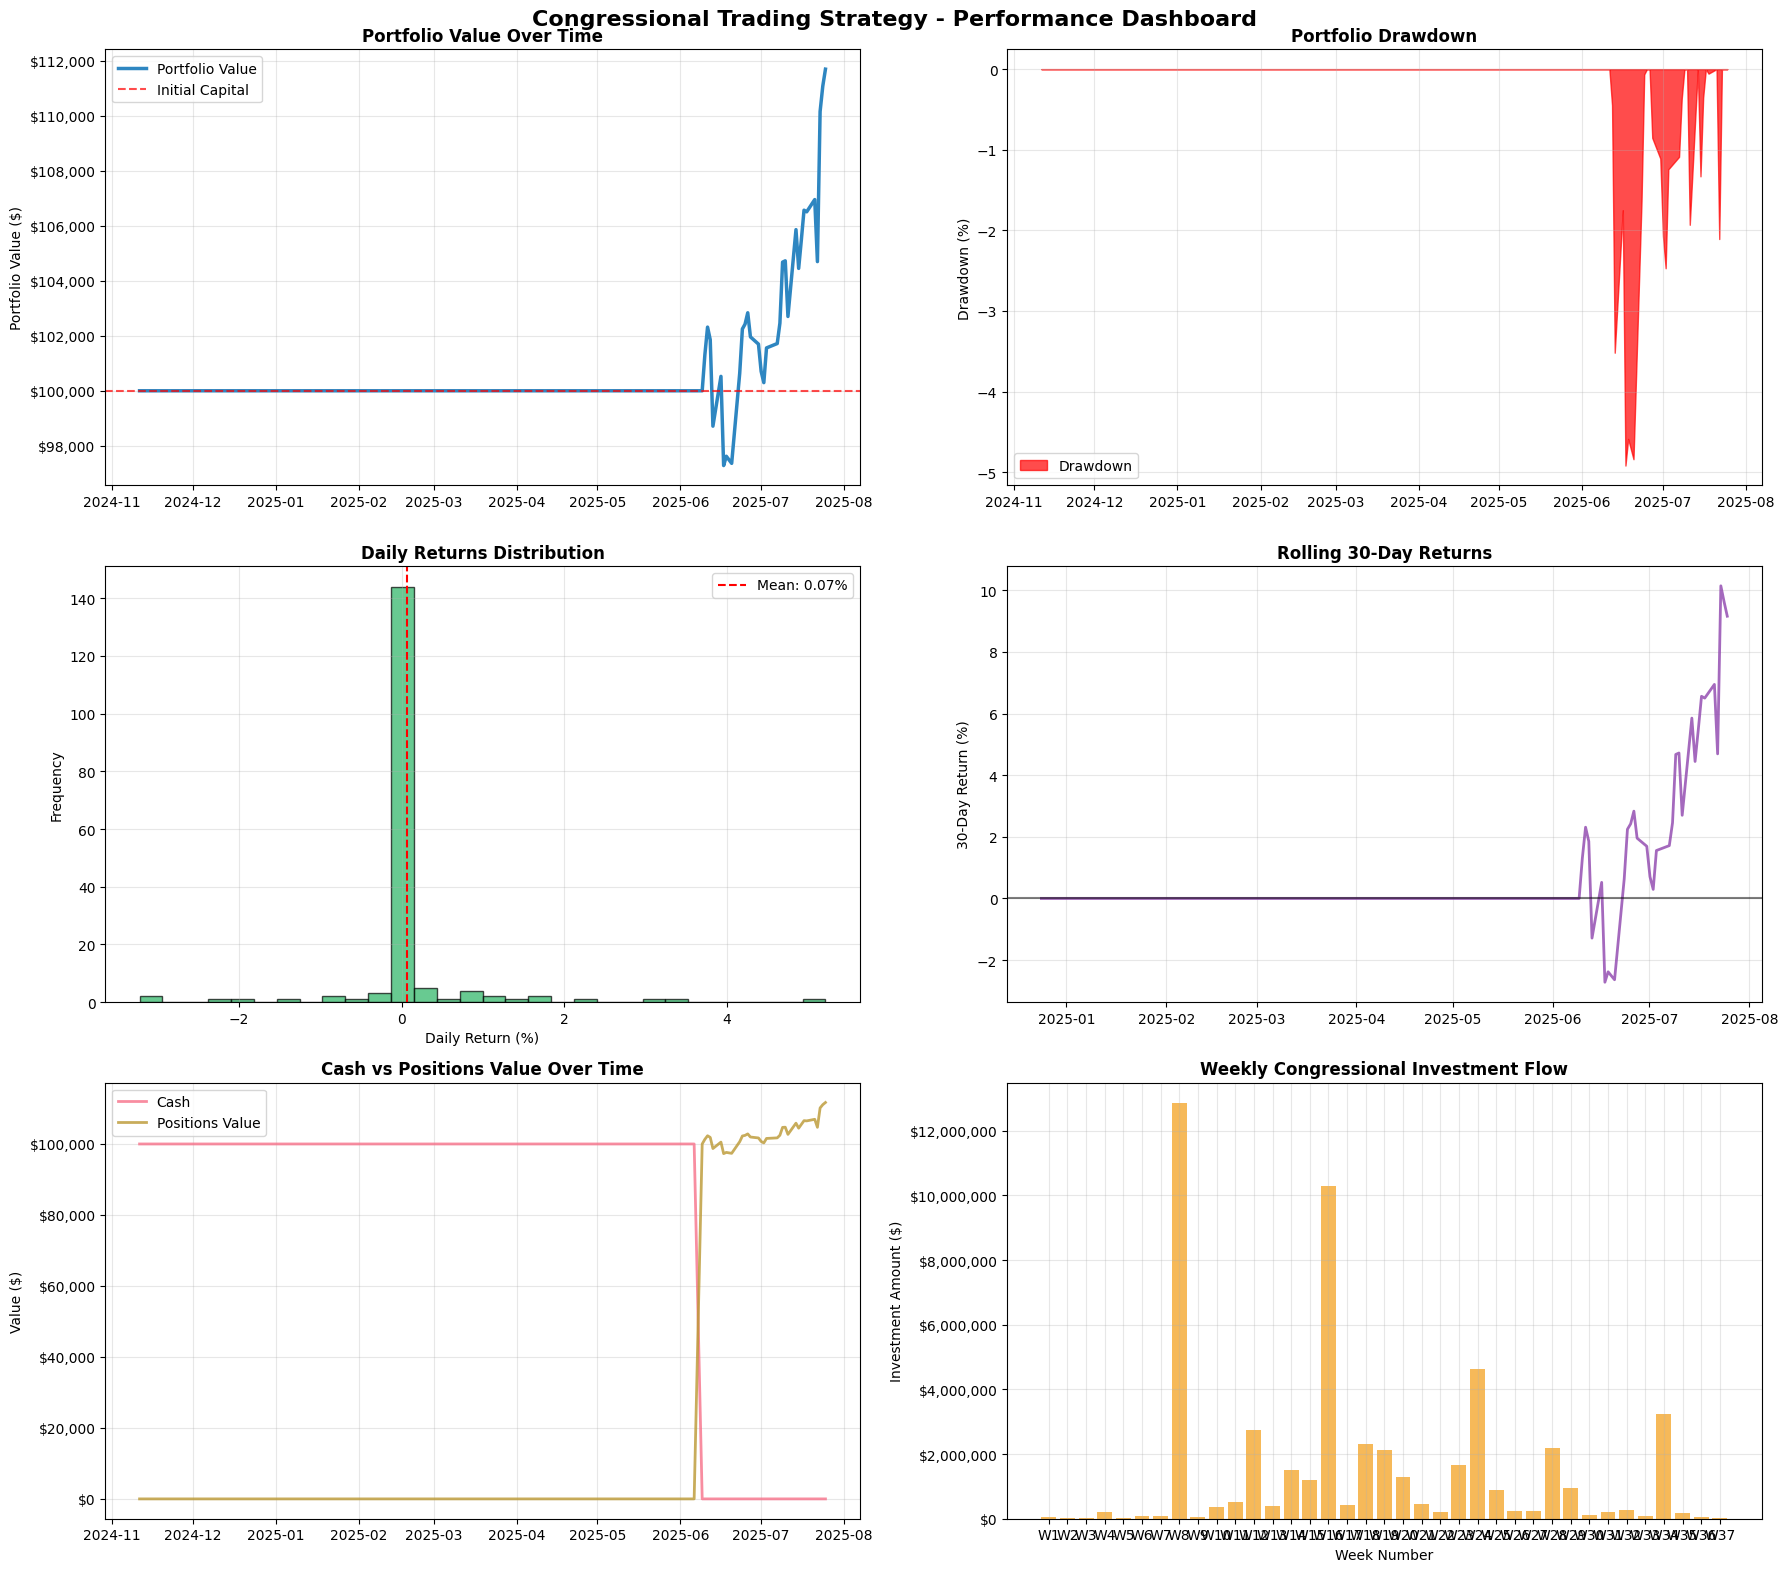

✅ Visualizations created successfully!


In [81]:
def backtest_strategy_final(weights_pivot, price_data, initial_capital=100000):
    """Final backtesting logic with proper timezone handling"""
    
    if weights_pivot.empty:
        print("No weights data for backtesting!")
        return pd.DataFrame()
    
    if price_data.empty:
        print("No price data for backtesting!")
        return pd.DataFrame()
    
    print(f"🚀 Starting backtest with ${initial_capital:,.2f}")
    
    # Check alignment between weights and price data
    weights_tickers = set(weights_pivot.columns)
    price_tickers = set(price_data.columns)
    common_tickers = list(weights_tickers & price_tickers)
    
    print(f"Weights tickers: {len(weights_tickers)} tickers")
    print(f"Price tickers: {len(price_tickers)} tickers") 
    print(f"Common tickers: {len(common_tickers)} tickers - {sorted(common_tickers)}")
    
    if not common_tickers:
        print("❌ No common tickers found!")
        return pd.DataFrame()
    
    # Filter to common tickers
    weights_filtered = weights_pivot[common_tickers]
    price_filtered = price_data[common_tickers].copy()  # Make a copy to avoid modifying original
    
    print(f"✅ Proceeding with {len(common_tickers)} tickers")
    
    # Fix timezone issues - ensure both price data and week dates are timezone-naive
    if hasattr(price_filtered.index, 'tz') and price_filtered.index.tz is not None:
        print(f"Original price data index timezone: {price_filtered.index.tz}")
        price_filtered.index = price_filtered.index.tz_convert('UTC').tz_localize(None)
        print("✅ Converted price data to timezone-naive")
    else:
        print("✅ Price data index is already timezone-naive")
    
    # Initialize portfolio tracking
    portfolio_history = []
    cash = initial_capital
    positions = {ticker: 0.0 for ticker in common_tickers}  # shares held
    
    # Get rebalancing dates with proper timezone handling
    rebalance_dates = []
    for week_period in weights_filtered.index:
        # Get week start time and ensure it's timezone-naive
        week_start = week_period.start_time
        
        # Convert to timezone-naive if needed
        if hasattr(week_start, 'tz') and week_start.tz is not None:
            week_start = week_start.tz_convert('UTC').tz_localize(None)
        
        # Convert to just date for comparison (remove time component)
        week_start_date = pd.Timestamp(week_start.date())
        
        # Find first trading day of that week or after
        available_dates = price_filtered.index[price_filtered.index >= week_start_date]
        if len(available_dates) > 0:
            rebalance_dates.append((week_period, available_dates[0]))
    
    print(f"📅 Will rebalance on {len(rebalance_dates)} dates")
    if len(rebalance_dates) <= 10:  # Show all if few dates
        for week, date in rebalance_dates:
            print(f"   {week} -> {date.strftime('%Y-%m-%d')}")
    else:  # Show first and last few if many dates
        for week, date in rebalance_dates[:3]:
            print(f"   {week} -> {date.strftime('%Y-%m-%d')}")
        print(f"   ... ({len(rebalance_dates)-6} more dates) ...")
        for week, date in rebalance_dates[-3:]:
            print(f"   {week} -> {date.strftime('%Y-%m-%d')}")
    
    # Main backtesting loop
    rebalance_count = 0
    
    for date in price_filtered.index:
        # Check if this is a rebalancing date
        current_rebalance = None
        for week_period, rebalance_date in rebalance_dates:
            # Compare dates directly (both should be timezone-naive now)
            if date.date() == rebalance_date.date():
                current_rebalance = week_period
                break
        
        if current_rebalance is not None:
            rebalance_count += 1
            target_weights = weights_filtered.loc[current_rebalance]
            
            # Calculate current portfolio value
            positions_value = 0
            for ticker in common_tickers:
                if not pd.isna(price_filtered.loc[date, ticker]):
                    positions_value += positions[ticker] * price_filtered.loc[date, ticker]
            
            total_portfolio_value = cash + positions_value
            
            if rebalance_count <= 5 or rebalance_count % 10 == 0:  # Reduce logging
                print(f"\n📊 REBALANCE #{rebalance_count} on {date.strftime('%Y-%m-%d')}:")
                print(f"   💰 Cash: ${cash:,.2f}")
                print(f"   📈 Positions value: ${positions_value:,.2f}")
                print(f"   💼 Total portfolio: ${total_portfolio_value:,.2f}")
            
            # Sell all current positions
            for ticker in common_tickers:
                if positions[ticker] > 0 and not pd.isna(price_filtered.loc[date, ticker]):
                    sell_value = positions[ticker] * price_filtered.loc[date, ticker]
                    cash += sell_value
                    positions[ticker] = 0
            
            # Buy new positions according to target weights
            active_positions = 0
            total_invested = 0
            
            for ticker in common_tickers:
                weight = target_weights[ticker]
                if weight > 0 and not pd.isna(price_filtered.loc[date, ticker]):
                    target_value = total_portfolio_value * weight
                    price = price_filtered.loc[date, ticker]
                    shares = target_value / price
                    
                    positions[ticker] = shares
                    cash -= target_value
                    total_invested += target_value
                    active_positions += 1
                    
                    if rebalance_count <= 3:  # Show details for first few rebalances
                        print(f"      🎯 {ticker}: {weight:.1%} -> ${target_value:,.2f} ({shares:.2f} shares @ ${price:.2f})")
            
            if rebalance_count <= 5 or rebalance_count % 10 == 0:
                print(f"   ✅ Invested ${total_invested:,.2f} in {active_positions} positions")
                print(f"   💵 Remaining cash: ${cash:,.2f}")
        
        # Calculate daily portfolio value
        positions_value = 0
        for ticker in common_tickers:
            if not pd.isna(price_filtered.loc[date, ticker]):
                positions_value += positions[ticker] * price_filtered.loc[date, ticker]
        
        total_value = cash + positions_value
        
        # Store daily values
        portfolio_history.append({
            'date': date,
            'portfolio_value': total_value,
            'cash': cash,
            'positions_value': positions_value,
            'total_return_pct': ((total_value / initial_capital) - 1) * 100
        })
    
    # Create results DataFrame
    results_df = pd.DataFrame(portfolio_history)
    results_df.set_index('date', inplace=True)
    
    print(f"\n🎉 BACKTESTING COMPLETED!")
    print(f"   📊 Total trading days: {len(results_df)}")
    print(f"   🔄 Total rebalances: {rebalance_count}")
    
    return results_df

# First, let's make sure we have the results_df and calculate all needed variables
try:
    # Check if results_df exists and has data
    if 'results_df' not in locals() or results_df.empty:
        print("Re-running backtest to get results...")
        results_df = backtest_strategy_final(weights_pivot, price_data, initial_capital=100000)
    else:
        print("✅ Using existing results_df")
        print(f"Results shape: {results_df.shape}")
except NameError:
    print("Re-running backtest to get results...")
    results_df = backtest_strategy_final(weights_pivot, price_data, initial_capital=100000)

def calculate_detailed_metrics(results_df, initial_capital=100000):
    """Calculate comprehensive performance metrics"""
    
    if results_df.empty:
        print("❌ No results data available for metrics calculation")
        return {}, pd.Series(), pd.Series()
    
    # Basic metrics
    final_value = results_df['portfolio_value'].iloc[-1]
    total_return = ((final_value / initial_capital) - 1) * 100
    
    # Time-based metrics
    start_date = results_df.index[0]
    end_date = results_df.index[-1]
    days_elapsed = (end_date - start_date).days
    years_elapsed = days_elapsed / 365.25
    
    # Returns analysis
    daily_returns = results_df['portfolio_value'].pct_change().dropna()
    
    # Annualized metrics
    if years_elapsed > 0:
        annualized_return = ((final_value / initial_capital) ** (1/years_elapsed) - 1) * 100
    else:
        annualized_return = 0
    
    # Risk metrics
    if len(daily_returns) > 1:
        volatility = daily_returns.std() * np.sqrt(252) * 100
        sharpe_ratio = (annualized_return/100 - 0.02) / (volatility/100) if volatility > 0 else 0
    else:
        volatility = 0
        sharpe_ratio = 0
    
    # Drawdown analysis
    rolling_max = results_df['portfolio_value'].expanding().max()
    drawdown = (results_df['portfolio_value'] - rolling_max) / rolling_max * 100
    max_drawdown = drawdown.min()
    
    # Win rate (days with positive returns)
    positive_days = (daily_returns > 0).sum()
    total_trading_days = len(daily_returns)
    win_rate = (positive_days / total_trading_days * 100) if total_trading_days > 0 else 0
    
    # Best and worst days
    best_day = daily_returns.max() * 100 if len(daily_returns) > 0 else 0
    worst_day = daily_returns.min() * 100 if len(daily_returns) > 0 else 0
    
    # Calmar ratio (annualized return / max drawdown)
    calmar_ratio = abs(annualized_return / max_drawdown) if max_drawdown != 0 else 0
    
    metrics = {
        'Initial Capital': f"${initial_capital:,.2f}",
        'Final Value': f"${final_value:,.2f}",
        'Total Return': f"{total_return:.2f}%",
        'Annualized Return': f"{annualized_return:.2f}%",
        'Volatility (Annual)': f"{volatility:.2f}%",
        'Sharpe Ratio': f"{sharpe_ratio:.2f}",
        'Max Drawdown': f"{max_drawdown:.2f}%",
        'Calmar Ratio': f"{calmar_ratio:.2f}",
        'Win Rate': f"{win_rate:.1f}%",
        'Best Day': f"{best_day:.2f}%",
        'Worst Day': f"{worst_day:.2f}%",
        'Total Days': days_elapsed,
        'Trading Days': total_trading_days
    }
    
    return metrics, daily_returns, drawdown

# Calculate detailed metrics
print("Calculating detailed performance metrics...")
detailed_metrics, daily_returns, drawdown_series = calculate_detailed_metrics(results_df)

if detailed_metrics:  # Only print if we have metrics
    print("\n🏆 DETAILED PERFORMANCE ANALYSIS")
    print("=" * 50)
    for metric, value in detailed_metrics.items():
        print(f"{metric:20}: {value}")
    
    # Quick verification
    print(f"\n✅ Successfully calculated metrics for {len(results_df)} days of data")
    print(f"📊 Portfolio grew from $100,000 to ${results_df['portfolio_value'].iloc[-1]:,.2f}")
    
else:
    print("❌ Could not calculate metrics - no results data available")

def create_strategy_visualizations(results_df, daily_returns, drawdown_series, weekly_investments):
    """Create comprehensive visualization dashboard"""
    
    if results_df.empty:
        print("❌ No results data available for visualization")
        return
    
    fig, axes = plt.subplots(3, 2, figsize=(18, 16))
    fig.suptitle('Congressional Trading Strategy - Performance Dashboard', fontsize=16, fontweight='bold')
    
    # 1. Portfolio Value Over Time
    axes[0, 0].plot(results_df.index, results_df['portfolio_value'], linewidth=2.5, color='#2E86C1', label='Portfolio Value')
    axes[0, 0].axhline(y=100000, color='red', linestyle='--', alpha=0.7, label='Initial Capital')
    axes[0, 0].set_title('Portfolio Value Over Time', fontweight='bold')
    axes[0, 0].set_ylabel('Portfolio Value ($)')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
    
    # 2. Drawdown Chart
    if not drawdown_series.empty:
        axes[0, 1].fill_between(results_df.index, drawdown_series, 0, alpha=0.7, color='red', label='Drawdown')
        axes[0, 1].set_title('Portfolio Drawdown', fontweight='bold')
        axes[0, 1].set_ylabel('Drawdown (%)')
        axes[0, 1].grid(True, alpha=0.3)
        axes[0, 1].legend()
    else:
        axes[0, 1].text(0.5, 0.5, 'No Drawdown Data', ha='center', va='center', transform=axes[0, 1].transAxes)
        axes[0, 1].set_title('Portfolio Drawdown', fontweight='bold')
    
    # 3. Daily Returns Distribution
    if not daily_returns.empty and len(daily_returns) > 1:
        axes[1, 0].hist(daily_returns * 100, bins=30, alpha=0.7, color='#28B463', edgecolor='black')
        axes[1, 0].axvline(daily_returns.mean() * 100, color='red', linestyle='--', label=f'Mean: {daily_returns.mean()*100:.2f}%')
        axes[1, 0].set_title('Daily Returns Distribution', fontweight='bold')
        axes[1, 0].set_xlabel('Daily Return (%)')
        axes[1, 0].set_ylabel('Frequency')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)
    else:
        axes[1, 0].text(0.5, 0.5, 'Insufficient Data for Distribution', ha='center', va='center', transform=axes[1, 0].transAxes)
        axes[1, 0].set_title('Daily Returns Distribution', fontweight='bold')
    
    # 4. Rolling 30-Day Returns
    if len(results_df) > 30:
        rolling_returns = results_df['portfolio_value'].pct_change(30) * 100
        axes[1, 1].plot(results_df.index, rolling_returns, linewidth=2, color='#8E44AD', alpha=0.8)
        axes[1, 1].axhline(y=0, color='black', linestyle='-', alpha=0.5)
        axes[1, 1].set_title('Rolling 30-Day Returns', fontweight='bold')
        axes[1, 1].set_ylabel('30-Day Return (%)')
        axes[1, 1].grid(True, alpha=0.3)
    else:
        axes[1, 1].text(0.5, 0.5, 'Insufficient Data for 30-Day Rolling', ha='center', va='center', transform=axes[1, 1].transAxes)
        axes[1, 1].set_title('Rolling 30-Day Returns', fontweight='bold')
    
    # 5. Cash vs Positions Value
    axes[2, 0].plot(results_df.index, results_df['cash'], label='Cash', alpha=0.8, linewidth=2)
    axes[2, 0].plot(results_df.index, results_df['positions_value'], label='Positions Value', alpha=0.8, linewidth=2)
    axes[2, 0].set_title('Cash vs Positions Value Over Time', fontweight='bold')
    axes[2, 0].set_ylabel('Value ($)')
    axes[2, 0].legend()
    axes[2, 0].grid(True, alpha=0.3)
    axes[2, 0].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
    
    # 6. Weekly Congressional Investment Flow
    if not weekly_investments.empty:
        weekly_totals = weekly_investments.groupby('week')['avg_investment'].sum()
        axes[2, 1].bar(range(len(weekly_totals)), weekly_totals.values, alpha=0.7, color='#F39C12')
        axes[2, 1].set_title('Weekly Congressional Investment Flow', fontweight='bold')
        axes[2, 1].set_xlabel('Week Number')
        axes[2, 1].set_ylabel('Investment Amount ($)')
        axes[2, 1].grid(True, alpha=0.3)
        axes[2, 1].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
        
        # Add week labels (simplified)
        week_labels = [f"W{i+1}" for i in range(len(weekly_totals))]
        axes[2, 1].set_xticks(range(len(weekly_totals)))
        axes[2, 1].set_xticklabels(week_labels)
    else:
        axes[2, 1].text(0.5, 0.5, 'No Congressional Investment Data', ha='center', va='center', transform=axes[2, 1].transAxes)
        axes[2, 1].set_title('Weekly Congressional Investment Flow', fontweight='bold')
    
    plt.tight_layout()
    plt.show()

# Create visualizations
print("\nCreating strategy visualizations...")
if not results_df.empty and detailed_metrics:
    create_strategy_visualizations(results_df, daily_returns, drawdown_series, weekly_investments)
    print("✅ Visualizations created successfully!")
else:
    print("❌ Cannot create visualizations - missing data")

In [70]:
def analyze_congressional_trades_comprehensive(df_buys, weights_pivot, weekly_investments, results_df):
    """Comprehensive analysis of congressional trading patterns using all available data"""
    
    print("📊 COMPREHENSIVE CONGRESSIONAL TRADING ANALYSIS")
    print("=" * 60)
    
    # Use the full dataset from df_buys if available
    if not df_buys.empty:
        print(f"📈 FULL DATASET ANALYSIS:")
        print(f"   • Total trading records: {len(df_buys):,}")
        print(f"   • Date range: {df_buys['purchase_date'].min().strftime('%Y-%m-%d')} to {df_buys['purchase_date'].max().strftime('%Y-%m-%d')}")
        print(f"   • Unique representatives: {df_buys['representative_name'].nunique()}")
        print(f"   • Unique tickers: {df_buys['ticker'].nunique()}")
        
        # Top investments by total amount
        stock_totals_full = df_buys.groupby('ticker')['avg_investment'].sum().sort_values(ascending=False)
        print(f"\n🏆 TOP 15 CONGRESSIONAL INVESTMENTS (FULL DATASET):")
        for i, (ticker, amount) in enumerate(stock_totals_full.head(15).items(), 1):
            print(f"{i:2d}. {ticker}: ${amount:,.2f}")
        
        # Most active representatives
        rep_activity = df_buys.groupby('representative_name').agg({
            'ticker': 'count',
            'avg_investment': 'sum'
        }).sort_values('avg_investment', ascending=False)
        rep_activity.columns = ['Number of Trades', 'Total Investment']
        
        print(f"\n👥 TOP 10 MOST ACTIVE REPRESENTATIVES:")
        for i, (rep, row) in enumerate(rep_activity.head(10).iterrows(), 1):
            print(f"{i:2d}. {rep}: {row['Number of Trades']} trades, ${row['Total Investment']:,.2f}")
        
        # Yearly breakdown
        df_buys['year'] = df_buys['purchase_date'].dt.year
        yearly_summary = df_buys.groupby('year').agg({
            'ticker': 'count',
            'avg_investment': 'sum',
            'representative_name': 'nunique'
        }).round(2)
        yearly_summary.columns = ['Total Trades', 'Total Investment', 'Unique Representatives']
        
        print(f"\n📅 YEARLY BREAKDOWN:")
        print(yearly_summary)
        
    else:
        print("⚠️ No full dataset available, using weekly investments data")
    
    # Analysis of weights_pivot (what's actually used in backtesting)
    if not weights_pivot.empty:
        print(f"\n🎯 BACKTESTING WEIGHTS ANALYSIS:")
        print(f"   • Number of rebalancing periods: {len(weights_pivot)}")
        print(f"   • Number of unique tickers: {len(weights_pivot.columns)}")
        print(f"   • Date range: {weights_pivot.index[0]} to {weights_pivot.index[-1]}")
        
        # Which tickers appear most frequently in the portfolio
        ticker_frequency = (weights_pivot > 0).sum().sort_values(ascending=False)
        print(f"\n📊 MOST FREQUENTLY HELD TICKERS (in portfolio):")
        for i, (ticker, freq) in enumerate(ticker_frequency.head(10).items(), 1):
            avg_weight = weights_pivot[ticker][weights_pivot[ticker] > 0].mean()
            print(f"{i:2d}. {ticker}: {freq} periods, avg weight: {avg_weight:.1%}")
    
    # Analysis of the limited weekly_investments data (what's causing the small output)
    if not weekly_investments.empty:
        print(f"\n⚠️ LIMITED WEEKLY DATA ANALYSIS:")
        print(f"   • This explains why you're seeing limited output!")
        print(f"   • Weekly investments records: {len(weekly_investments)}")
        print(f"   • Unique weeks: {weekly_investments['week'].nunique()}")
        print(f"   • This is only a small subset of your full data!")
        
        stock_totals_limited = weekly_investments.groupby('ticker')['avg_investment'].sum().sort_values(ascending=False)
        print(f"\n📉 LIMITED DATASET - TOP INVESTMENTS:")
        for i, (ticker, amount) in enumerate(stock_totals_limited.items(), 1):
            print(f"{i:2d}. {ticker}: ${amount:,.2f}")
    
    # Performance analysis if results available
    if not results_df.empty:
        print(f"\n📈 STRATEGY PERFORMANCE SUMMARY:")
        initial_value = results_df['portfolio_value'].iloc[0]
        final_value = results_df['portfolio_value'].iloc[-1]
        total_return = ((final_value / initial_value) - 1) * 100
        
        print(f"   • Initial Value: ${initial_value:,.2f}")
        print(f"   • Final Value: ${final_value:,.2f}")
        print(f"   • Total Return: {total_return:.2f}%")
        print(f"   • Trading Days: {len(results_df)}")
    
    return stock_totals_full if not df_buys.empty else pd.Series(), yearly_summary if not df_buys.empty else pd.DataFrame()

# Run comprehensive analysis
print("Running comprehensive congressional trading analysis...")
stock_analysis_full, yearly_breakdown = analyze_congressional_trades_comprehensive(
    df_buys, weights_pivot, weekly_investments, results_df
)

Running comprehensive congressional trading analysis...
📊 COMPREHENSIVE CONGRESSIONAL TRADING ANALYSIS
📈 FULL DATASET ANALYSIS:
   • Total trading records: 1,495
   • Date range: 2015-05-08 to 2025-07-15
   • Unique representatives: 39
   • Unique tickers: 459

🏆 TOP 15 CONGRESSIONAL INVESTMENTS (FULL DATASET):
 1. MSFT: $22,801,013.00
 2. AVGO: $3,344,008.50
 3. NVDA: $1,565,015.00
 4. OUNZ: $1,332,502.00
 5. HOG: $842,507.50
 6. VST: $790,501.50
 7. F: $732,009.50
 8. AMZN: $699,013.50
 9. AAL: $585,005.50
10. GOOG: $495,506.50
11. SMCY: $390,002.50
12. AAPL: $387,006.50
13. JNJ: $242,009.00
14. UNH: $235,005.50
15. TXN: $220,505.00

👥 TOP 10 MOST ACTIVE REPRESENTATIVES:
 1. GottheimerJosh: 129.0 trades, $22,785,064.50
 2. ShreveJefferson: 189.0 trades, $8,550,094.50
 3. PelosiNancy: 6.0 trades, $5,625,003.00
 4. MooreTim: 53.0 trades, $2,755,026.00
 5. BresnahanRob: 247.0 trades, $2,606,623.50
 6. GreeneMarjorie Taylor: 215.0 trades, $1,793,607.50
 7. CisnerosGilbert: 116.0 trades, 

Performing advanced risk analysis with CURRENT session data...
⚠️ ADVANCED RISK ANALYSIS
🔍 DATA VERIFICATION:
   • Using results_df with 175 trading days
   • Date range: 2024-11-11 to 2025-07-25
   • Portfolio start: $100,000.00
   • Portfolio end: $111,686.89

📊 Using 174 days of return data
📅 Analysis period: 2024-11-11 to 2025-07-25

📊 RISK METRICS (CURRENT DATA):
  Value at Risk (95%):     -0.31%
  Value at Risk (99%):     -2.37%
  Conditional VaR (95%):   -1.60%
  Conditional VaR (99%):   -3.15%
  Maximum Drawdown:        -4.92%
  Volatility (Annualized): 11.95%
  Skewness:                1.84
  Kurtosis:                19.30
  Downside Deviation:      17.54%
  Sharpe Ratio:            1.28
  Sortino Ratio:           0.87

🎯 RISK INTERPRETATION:
📉 VALUE AT RISK (VaR):
  • 95% VaR of -0.31% means: On 95% of days, your daily loss won't exceed 0.31%
  • 99% VaR of -2.37% means: On 99% of days, your daily loss won't exceed 2.37%
  • In other words: There's a 5% chance of losing more 

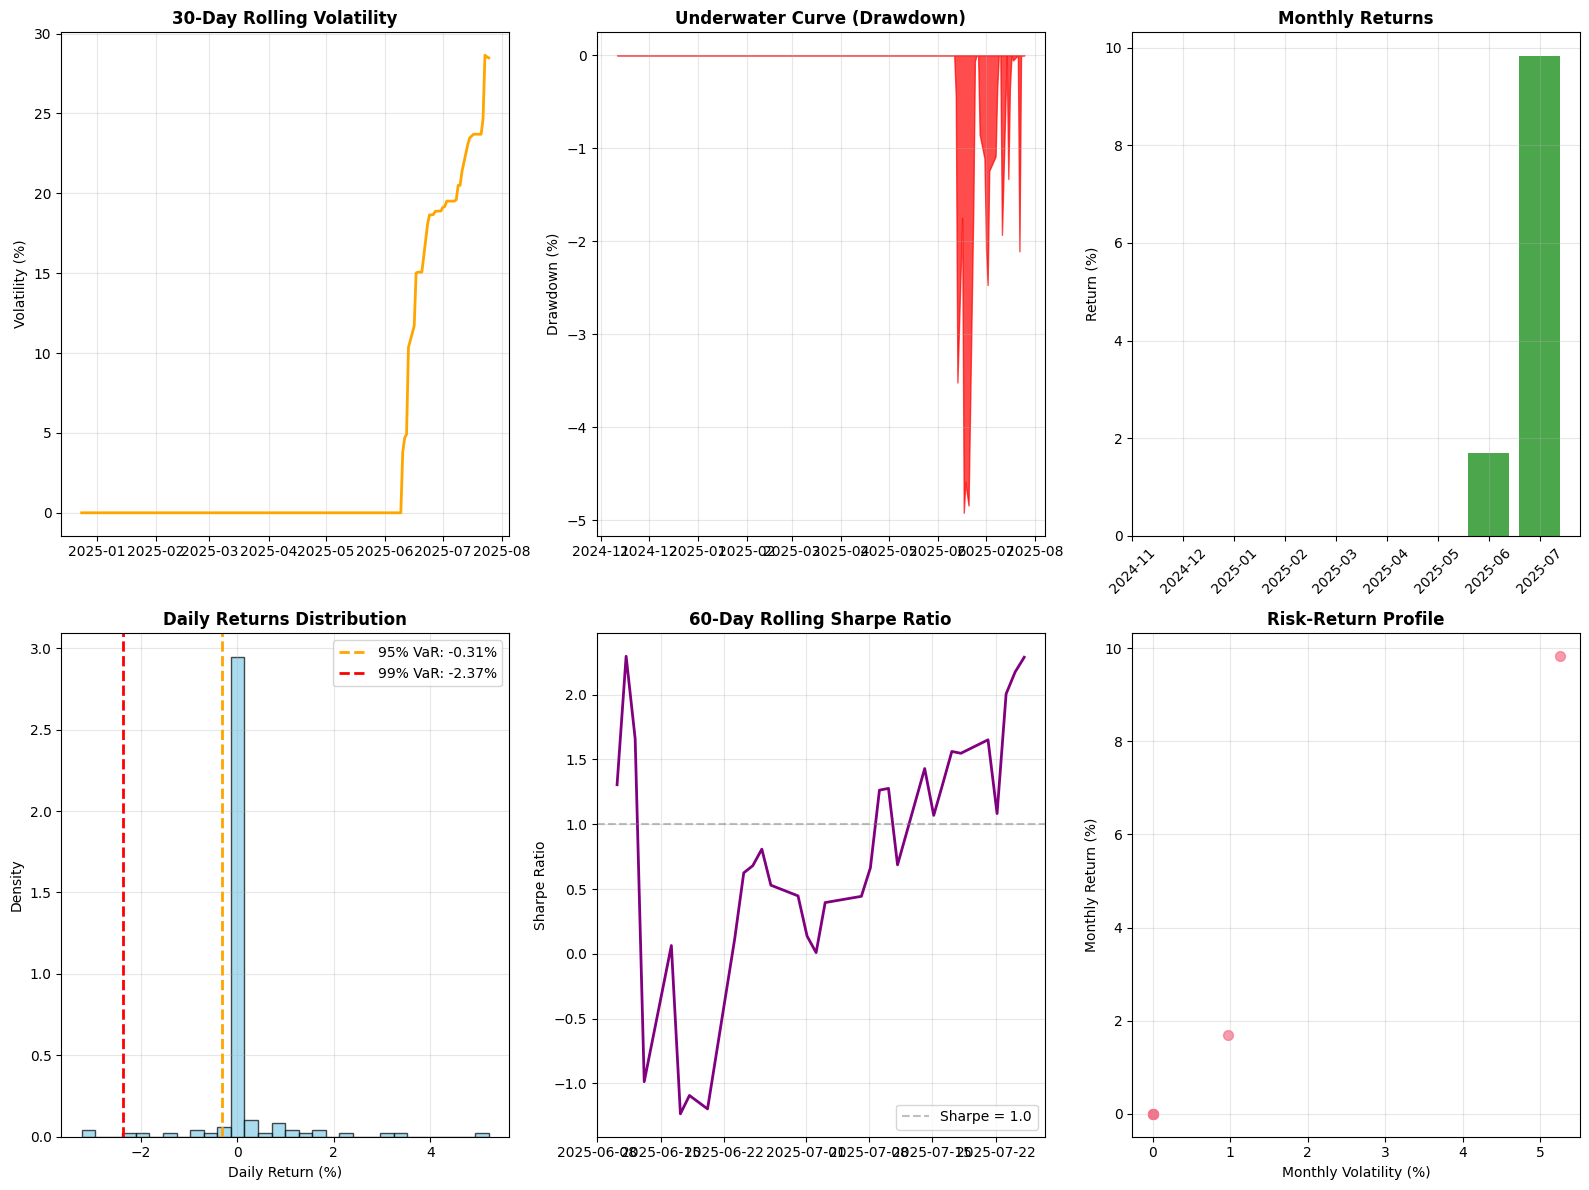


✅ Risk analysis complete! Key takeaways from CURRENT data:
   • Your strategy has a 1.28 Sharpe ratio
   • Total return: 11.69%
   • Annualized return: 17.25%
   • Maximum single-day loss expectation: 0.31% (95% confidence)
   • Worst drawdown experienced: 4.92%
   • Strategy volatility: 11.95% annually


In [61]:
def advanced_risk_analysis():
    """Perform advanced risk analysis with qualitative interpretations using current session data"""
    
    # Get current session data directly
    current_results_df = globals().get('results_df', pd.DataFrame())
    
    if current_results_df.empty:
        print("❌ No results data available for risk analysis")
        print("Please run the backtest first to generate results_df")
        return
    
    print("⚠️ ADVANCED RISK ANALYSIS")
    print("=" * 50)
    
    # Debug: Verify we're using current data
    print(f"🔍 DATA VERIFICATION:")
    print(f"   • Using results_df with {len(current_results_df)} trading days")
    print(f"   • Date range: {current_results_df.index[0].strftime('%Y-%m-%d')} to {current_results_df.index[-1].strftime('%Y-%m-%d')}")
    print(f"   • Portfolio start: ${current_results_df['portfolio_value'].iloc[0]:,.2f}")
    print(f"   • Portfolio end: ${current_results_df['portfolio_value'].iloc[-1]:,.2f}")
    
    # Recalculate daily returns from current data
    portfolio_values = current_results_df['portfolio_value'].copy()
    fresh_daily_returns = portfolio_values.pct_change().dropna()
    
    print(f"\n📊 Using {len(fresh_daily_returns)} days of return data")
    print(f"📅 Analysis period: {current_results_df.index[0].strftime('%Y-%m-%d')} to {current_results_df.index[-1].strftime('%Y-%m-%d')}")
    
    # Value at Risk (VaR) calculations
    var_95 = np.percentile(fresh_daily_returns, 5) * 100
    var_99 = np.percentile(fresh_daily_returns, 1) * 100
    
    # Conditional Value at Risk (CVaR) - average of worst 5% and 1% of days
    cvar_95 = fresh_daily_returns[fresh_daily_returns <= np.percentile(fresh_daily_returns, 5)].mean() * 100
    cvar_99 = fresh_daily_returns[fresh_daily_returns <= np.percentile(fresh_daily_returns, 1)].mean() * 100
    
    # Skewness and Kurtosis
    skewness = fresh_daily_returns.skew()
    kurtosis = fresh_daily_returns.kurtosis()
    
    # Calculate proper annualized metrics from current data
    total_days = len(current_results_df)
    total_return = (current_results_df['portfolio_value'].iloc[-1] / 100000 - 1) * 100
    annualized_return = ((current_results_df['portfolio_value'].iloc[-1] / 100000) ** (252/total_days) - 1) * 100
    
    # Volatility calculations
    volatility = fresh_daily_returns.std() * np.sqrt(252) * 100
    
    # Sortino Ratio (downside deviation)
    downside_returns = fresh_daily_returns[fresh_daily_returns < 0]
    downside_deviation = downside_returns.std() * np.sqrt(252) * 100 if len(downside_returns) > 0 else 0
    
    # Risk-adjusted ratios
    risk_free_rate = 2.0  # Assume 2% risk-free rate
    sharpe_ratio = (annualized_return - risk_free_rate) / volatility if volatility > 0 else 0
    sortino_ratio = (annualized_return - risk_free_rate) / downside_deviation if downside_deviation > 0 else 0
    
    # Maximum drawdown
    rolling_max = portfolio_values.expanding().max()
    drawdown = (portfolio_values - rolling_max) / rolling_max * 100
    max_drawdown = drawdown.min()
    
    print(f"\n📊 RISK METRICS (CURRENT DATA):")
    print(f"  Value at Risk (95%):     {var_95:.2f}%")
    print(f"  Value at Risk (99%):     {var_99:.2f}%")
    print(f"  Conditional VaR (95%):   {cvar_95:.2f}%")
    print(f"  Conditional VaR (99%):   {cvar_99:.2f}%")
    print(f"  Maximum Drawdown:        {max_drawdown:.2f}%")
    print(f"  Volatility (Annualized): {volatility:.2f}%")
    print(f"  Skewness:                {skewness:.2f}")
    print(f"  Kurtosis:                {kurtosis:.2f}")
    print(f"  Downside Deviation:      {downside_deviation:.2f}%")
    print(f"  Sharpe Ratio:            {sharpe_ratio:.2f}")
    print(f"  Sortino Ratio:           {sortino_ratio:.2f}")
    
    # QUALITATIVE RISK INTERPRETATION
    print(f"\n🎯 RISK INTERPRETATION:")
    print("=" * 30)
    
    # VaR Interpretation
    print(f"📉 VALUE AT RISK (VaR):")
    print(f"  • 95% VaR of {var_95:.2f}% means: On 95% of days, your daily loss won't exceed {abs(var_95):.2f}%")
    print(f"  • 99% VaR of {var_99:.2f}% means: On 99% of days, your daily loss won't exceed {abs(var_99):.2f}%")
    print(f"  • In other words: There's a 5% chance of losing more than {abs(var_95):.2f}% in a single day")
    print(f"  • And only a 1% chance of losing more than {abs(var_99):.2f}% in a single day")
    
    # CVaR Interpretation
    print(f"\n📊 CONDITIONAL VaR (Expected Shortfall):")
    print(f"  • CVaR 95% of {cvar_95:.2f}% means: When you do have a bad day (worst 5%), expect to lose {abs(cvar_95):.2f}% on average")
    print(f"  • CVaR 99% of {cvar_99:.2f}% means: On your very worst days (worst 1%), expect to lose {abs(cvar_99):.2f}% on average")
    
    # Drawdown Interpretation
    print(f"\n📉 DRAWDOWN ANALYSIS:")
    print(f"  • Maximum drawdown of {max_drawdown:.2f}% means: Your worst peak-to-trough loss was {abs(max_drawdown):.2f}%")
    if abs(max_drawdown) < 5:
        print(f"  • This is EXCELLENT - very low maximum loss from peak")
    elif abs(max_drawdown) < 10:
        print(f"  • This is GOOD - reasonable maximum loss from peak")
    elif abs(max_drawdown) < 20:
        print(f"  • This is MODERATE - acceptable maximum loss from peak")
    else:
        print(f"  • This is HIGH - significant maximum loss from peak")
    
    # Volatility Interpretation
    print(f"\n📊 VOLATILITY ANALYSIS:")
    print(f"  • Annual volatility of {volatility:.2f}% means your returns typically vary by ±{volatility:.1f}% per year")
    if volatility < 15:
        print(f"  • This is LOW volatility - your strategy is quite stable")
    elif volatility < 25:
        print(f"  • This is MODERATE volatility - typical for equity strategies")
    else:
        print(f"  • This is HIGH volatility - your strategy has significant swings")
    
    # Skewness and Kurtosis Interpretation
    print(f"\n📈 DISTRIBUTION ANALYSIS:")
    if skewness > 0.5:
        print(f"  • Positive skewness ({skewness:.2f}) = More frequent small losses, occasional large gains ✅")
    elif skewness < -0.5:
        print(f"  • Negative skewness ({skewness:.2f}) = More frequent small gains, occasional large losses ⚠️")
    else:
        print(f"  • Near-zero skewness ({skewness:.2f}) = Roughly symmetric return distribution")
    
    if kurtosis > 3:
        print(f"  • High kurtosis ({kurtosis:.2f}) = Fat tails - more extreme returns than normal distribution")
    else:
        print(f"  • Normal kurtosis ({kurtosis:.2f}) = Returns follow roughly normal distribution")
    
    # Risk-Adjusted Performance
    print(f"\n⚡ RISK-ADJUSTED PERFORMANCE:")
    if sharpe_ratio > 1.5:
        print(f"  • Sharpe ratio of {sharpe_ratio:.2f} is EXCELLENT - great return per unit of risk")
    elif sharpe_ratio > 1.0:
        print(f"  • Sharpe ratio of {sharpe_ratio:.2f} is GOOD - decent return per unit of risk")
    elif sharpe_ratio > 0.5:
        print(f"  • Sharpe ratio of {sharpe_ratio:.2f} is FAIR - moderate return per unit of risk")
    else:
        print(f"  • Sharpe ratio of {sharpe_ratio:.2f} is LOW - poor return per unit of risk")
    
    if sortino_ratio > sharpe_ratio:
        print(f"  • Sortino ratio ({sortino_ratio:.2f}) > Sharpe ratio = Your upside volatility is beneficial")
    
    # Overall Risk Assessment
    print(f"\n🎯 OVERALL RISK ASSESSMENT:")
    risk_score = 0
    if abs(max_drawdown) < 10: risk_score += 1
    if volatility < 20: risk_score += 1
    if sharpe_ratio > 1.0: risk_score += 1
    if var_95 > -2: risk_score += 1
    
    if risk_score >= 3:
        print(f"  🟢 LOW RISK STRATEGY - Well-controlled downside with good risk-adjusted returns")
    elif risk_score >= 2:
        print(f"  🟡 MODERATE RISK STRATEGY - Reasonable risk profile for the returns generated")
    else:
        print(f"  🔴 HIGH RISK STRATEGY - Significant risk factors to monitor")
    
    # Practical Risk Context
    print(f"\n💡 PRACTICAL RISK CONTEXT:")
    print(f"  📊 WHAT THIS MEANS FOR YOUR STRATEGY:")
    
    # Daily risk context
    worst_5_percent_days = int(len(fresh_daily_returns) * 0.05)
    worst_1_percent_days = int(len(fresh_daily_returns) * 0.01)
    
    print(f"  • Out of {len(fresh_daily_returns)} trading days:")
    print(f"    - On {len(fresh_daily_returns) - worst_5_percent_days} days (~95%), you lost less than {abs(var_95):.2f}%")
    print(f"    - On {worst_5_percent_days} worst days (~5%), you lost {abs(var_95):.2f}% or more")
    print(f"    - On {worst_1_percent_days} very worst days (~1%), you lost {abs(var_99):.2f}% or more")
    
    # Portfolio value context
    portfolio_start = current_results_df['portfolio_value'].iloc[0]
    var_95_dollar = portfolio_start * abs(var_95) / 100
    var_99_dollar = portfolio_start * abs(var_99) / 100
    max_dd_dollar = portfolio_start * abs(max_drawdown) / 100
    
    print(f"\n  💰 IN DOLLAR TERMS (based on ${portfolio_start:,.0f} portfolio):")
    print(f"    - 95% VaR: Risk losing more than ${var_95_dollar:,.0f} in a single day (5% chance)")
    print(f"    - 99% VaR: Risk losing more than ${var_99_dollar:,.0f} in a single day (1% chance)")
    print(f"    - Max Drawdown: Worst loss from peak was ${max_dd_dollar:,.0f}")
    
    # Create visualization
    plt.figure(figsize=(16, 12))
    
    # Rolling 30-day volatility
    plt.subplot(2, 3, 1)
    rolling_vol = portfolio_values.pct_change().rolling(30).std() * np.sqrt(252) * 100
    plt.plot(current_results_df.index, rolling_vol, color='orange', linewidth=2)
    plt.title('30-Day Rolling Volatility', fontweight='bold')
    plt.ylabel('Volatility (%)')
    plt.grid(True, alpha=0.3)
    
    # Underwater curve (drawdown)
    plt.subplot(2, 3, 2)
    plt.fill_between(current_results_df.index, drawdown, 0, alpha=0.7, color='red')
    plt.title('Underwater Curve (Drawdown)', fontweight='bold')
    plt.ylabel('Drawdown (%)')
    plt.grid(True, alpha=0.3)
    
    # Monthly returns
    plt.subplot(2, 3, 3)
    monthly_returns = portfolio_values.resample('M').last().pct_change() * 100
    if len(monthly_returns) > 1:
        colors = ['green' if x > 0 else 'red' for x in monthly_returns.values]
        plt.bar(range(len(monthly_returns)), monthly_returns.values, color=colors, alpha=0.7)
        plt.title('Monthly Returns', fontweight='bold')
        plt.ylabel('Return (%)')
        plt.xticks(range(len(monthly_returns)), 
                   [d.strftime('%Y-%m') for d in monthly_returns.index], rotation=45)
        plt.grid(True, alpha=0.3)
    else:
        plt.text(0.5, 0.5, 'Insufficient data\nfor monthly analysis', 
                ha='center', va='center', transform=plt.gca().transAxes, fontsize=12)
        plt.title('Monthly Returns', fontweight='bold')
    
    # Return distribution with VaR markers
    plt.subplot(2, 3, 4)
    plt.hist(fresh_daily_returns * 100, bins=30, alpha=0.7, density=True, color='skyblue', edgecolor='black')
    
    # Add VaR lines
    plt.axvline(var_95, color='orange', linestyle='--', linewidth=2, label=f'95% VaR: {var_95:.2f}%')
    plt.axvline(var_99, color='red', linestyle='--', linewidth=2, label=f'99% VaR: {var_99:.2f}%')
    
    plt.title('Daily Returns Distribution', fontweight='bold')
    plt.xlabel('Daily Return (%)')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Rolling Sharpe ratio
    plt.subplot(2, 3, 5)
    rolling_sharpe = (portfolio_values.pct_change().rolling(60).mean() * 252 - risk_free_rate/100) / (portfolio_values.pct_change().rolling(60).std() * np.sqrt(252))
    plt.plot(current_results_df.index, rolling_sharpe, color='purple', linewidth=2)
    plt.axhline(y=1.0, color='gray', linestyle='--', alpha=0.5, label='Sharpe = 1.0')
    plt.title('60-Day Rolling Sharpe Ratio', fontweight='bold')
    plt.ylabel('Sharpe Ratio')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Risk-Return scatter or summary stats
    plt.subplot(2, 3, 6)
    if len(monthly_returns) > 3:
        monthly_vol = monthly_returns.rolling(3).std()
        plt.scatter(monthly_vol, monthly_returns, alpha=0.7, s=50)
        plt.xlabel('Monthly Volatility (%)')
        plt.ylabel('Monthly Return (%)')
        plt.title('Risk-Return Profile', fontweight='bold')
        plt.grid(True, alpha=0.3)
    else:
        plt.text(0.5, 0.5, f'Current Portfolio Statistics:\n\nTotal Return: {total_return:.1f}%\nAnnualized: {annualized_return:.1f}%\nSharpe: {sharpe_ratio:.2f}\nMax DD: {max_drawdown:.1f}%\nVaR 95%: {var_95:.2f}%', 
                ha='center', va='center', transform=plt.gca().transAxes, fontsize=11,
                bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))
        plt.title('Current Strategy Summary', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    return {
        'var_95': var_95,
        'var_99': var_99,
        'cvar_95': cvar_95,
        'cvar_99': cvar_99,
        'max_drawdown': max_drawdown,
        'sharpe_ratio': sharpe_ratio,
        'sortino_ratio': sortino_ratio,
        'volatility': volatility,
        'total_return': total_return,
        'annualized_return': annualized_return
    }

# Run advanced risk analysis with current session data
print("Performing advanced risk analysis with CURRENT session data...")
risk_metrics = advanced_risk_analysis()

if risk_metrics:
    print(f"\n✅ Risk analysis complete! Key takeaways from CURRENT data:")
    print(f"   • Your strategy has a {risk_metrics['sharpe_ratio']:.2f} Sharpe ratio")
    print(f"   • Total return: {risk_metrics['total_return']:.2f}%")
    print(f"   • Annualized return: {risk_metrics['annualized_return']:.2f}%")
    print(f"   • Maximum single-day loss expectation: {abs(risk_metrics['var_95']):.2f}% (95% confidence)")
    print(f"   • Worst drawdown experienced: {abs(risk_metrics['max_drawdown']):.2f}%")
    print(f"   • Strategy volatility: {risk_metrics['volatility']:.2f}% annually")
else:
    print("❌ Cannot perform risk analysis - missing results data")

In [60]:
def print_comprehensive_strategy_recap():
    """Print a comprehensive recap using current session data"""
    
    print("🏛️ CONGRESSIONAL TRADING STRATEGY - COMPREHENSIVE ANALYSIS RECAP")
    print("=" * 80)
    
    # Get current session data - ensure we're using fresh variables
    current_results_df = globals().get('results_df', pd.DataFrame())
    current_df_buys = globals().get('df_buys', pd.DataFrame())
    current_weights_pivot = globals().get('weights_pivot', pd.DataFrame())
    current_weekly_investments = globals().get('weekly_investments', pd.DataFrame())
    
    # Debug: Print data info to verify we're using current data
    print(f"🔍 DATA VERIFICATION:")
    print(f"   • Results DataFrame: {len(current_results_df)} rows")
    print(f"   • Congressional Trades: {len(current_df_buys)} trades")
    print(f"   • Weekly Investments: {len(current_weekly_investments)} entries")
    print(f"   • Weights Pivot: {current_weights_pivot.shape if not current_weights_pivot.empty else 'Empty'}")
    
    if current_df_buys.empty:
        print("❌ No congressional trading data available - please run data loading first")
        return
    
    if current_results_df.empty:
        print("❌ No backtest results available - please run backtest first")
        return
    
    # Strategy Overview with detailed explanation
    print(f"\n📋 STRATEGY OVERVIEW & METHODOLOGY:")
    print(f"   • Strategy Type: Congressional Trading Following Strategy")
    print(f"   • Core Concept: Mirror the stock purchases of US Congress members")
    print(f"   • Investment Thesis: Congress members may have access to material non-public information")
    print(f"   • Approach: Weekly rebalancing based on disclosed congressional stock purchases")
    print(f"   • Position Sizing: Weighted by congressional investment amounts per ticker")
    print(f"   • Data Source: PelosiForThePeople congressional trading disclosures")
    print(f"   • Initial Capital: $100,000")
    print(f"   • Rebalancing: Every Friday based on new congressional activity")
    
    # Time Range Analysis - use CURRENT data
    start_date = current_results_df.index[0]
    end_date = current_results_df.index[-1]
    total_days = (end_date - start_date).days
    trading_days = len(current_results_df)
    
    # Also show the FULL data range from congressional trades
    full_data_start = current_df_buys['purchase_date'].min()
    full_data_end = current_df_buys['purchase_date'].max()
    full_data_years = (full_data_end - full_data_start).days / 365.25
    
    print(f"\n📅 DATA COVERAGE ANALYSIS:")
    print(f"   📊 FULL CONGRESSIONAL DATA RANGE:")
    print(f"      • Earliest Trade: {full_data_start.strftime('%Y-%m-%d')}")
    print(f"      • Latest Trade: {full_data_end.strftime('%Y-%m-%d')}")
    print(f"      • Total Data Span: {full_data_years:.1f} years")
    print(f"      • Total Congressional Trades: {len(current_df_buys):,}")
    
    print(f"\n   🎯 BACKTEST PERIOD:")
    print(f"      • Start Date: {start_date.strftime('%Y-%m-%d (%A)')}")
    print(f"      • End Date: {end_date.strftime('%Y-%m-%d (%A)')}")
    print(f"      • Total Calendar Days: {total_days}")
    print(f"      • Trading Days: {trading_days}")
    print(f"      • Period Length: ~{total_days/30:.1f} months ({total_days/365.25:.2f} years)")
    print(f"      • Market Coverage: {trading_days/total_days*100:.1f}% of calendar days")
    
    # Congressional Activity Deep Analysis - use CURRENT data
    unique_representatives = current_df_buys['representative_name'].nunique() if 'representative_name' in current_df_buys.columns else 0
    unique_tickers = current_df_buys['ticker'].nunique()
    total_trades = len(current_df_buys)
    
    # Calculate investment amounts properly
    if 'avg_investment' in current_df_buys.columns:
        total_investment = current_df_buys['avg_investment'].sum()
        avg_investment_per_trade = total_investment / total_trades if total_trades > 0 else 0
    else:
        total_investment = 0
        avg_investment_per_trade = 0
    
    print(f"\n🏛️ CONGRESSIONAL TRADING ACTIVITY DEEP DIVE:")
    print(f"   📊 VOLUME METRICS (CURRENT DATA):")
    print(f"      • Total Congressional Trades: {total_trades:,}")
    print(f"      • Unique Representatives: {unique_representatives}")
    print(f"      • Unique Stocks Traded: {unique_tickers}")
    print(f"      • Total Congressional Investment: ${total_investment:,.2f}")
    print(f"      • Average Investment per Trade: ${avg_investment_per_trade:,.2f}")
    
    # Yearly breakdown
    if 'purchase_date' in current_df_buys.columns:
        current_df_buys['year'] = current_df_buys['purchase_date'].dt.year
        yearly_counts = current_df_buys['year'].value_counts().sort_index()
        print(f"\n   📅 YEARLY BREAKDOWN:")
        for year, count in yearly_counts.items():
            percentage = (count / total_trades) * 100
            print(f"      • {year}: {count:,} trades ({percentage:.1f}%)")
    
    # Weekly analysis for backtest period
    if not current_weekly_investments.empty:
        unique_weeks = current_weekly_investments['week'].nunique()
        trades_in_backtest = len(current_weekly_investments)
        
        print(f"\n   📈 BACKTEST PERIOD ACTIVITY:")
        print(f"      • Active Trading Weeks: {unique_weeks}")
        print(f"      • Trades in Backtest Period: {trades_in_backtest:,}")
        print(f"      • Average Trades per Week: {trades_in_backtest/unique_weeks:.1f}")
        
        if 'avg_investment' in current_weekly_investments.columns:
            backtest_investment = current_weekly_investments['avg_investment'].sum()
            print(f"      • Total Investment in Backtest: ${backtest_investment:,.2f}")
    
    # Top stocks analysis - use CURRENT data
    if 'avg_investment' in current_df_buys.columns:
        stock_analysis = current_df_buys.groupby('ticker')['avg_investment'].sum().sort_values(ascending=False)
        
        print(f"\n   🏆 TOP CONGRESSIONAL INVESTMENTS (CURRENT DATA):")
        for i, (ticker, amount) in enumerate(stock_analysis.head(10).items(), 1):
            percentage = (amount / total_investment) * 100 if total_investment > 0 else 0
            print(f"      {i}. {ticker}: ${amount:,.2f} ({percentage:.1f}% of total)")
            if i <= 5:
                if percentage > 20:
                    print(f"         💡 MAJOR FOCUS: This stock represents significant congressional interest")
                elif percentage > 10:
                    print(f"         📈 HIGH INTEREST: Strong congressional conviction in this position")
                elif percentage > 5:
                    print(f"         ✅ SOLID INTEREST: Meaningful congressional activity")
    
    # Performance Metrics - calculate from CURRENT results_df
    total_return = (current_results_df['portfolio_value'].iloc[-1] / 100000 - 1) * 100
    annualized_return = ((current_results_df['portfolio_value'].iloc[-1] / 100000) ** (252/len(current_results_df)) - 1) * 100
    daily_returns = current_results_df['portfolio_value'].pct_change().dropna()
    volatility = daily_returns.std() * np.sqrt(252) * 100
    sharpe_ratio = (annualized_return - 2) / volatility if volatility > 0 else 0
    
    # Calculate drawdown
    rolling_max = current_results_df['portfolio_value'].expanding().max()
    drawdown = (current_results_df['portfolio_value'] - rolling_max) / rolling_max * 100
    max_drawdown = drawdown.min()
    
    # Win rate
    positive_days = (daily_returns > 0).sum()
    win_rate = (positive_days / len(daily_returns)) * 100 if len(daily_returns) > 0 else 0
    
    print(f"\n📊 PERFORMANCE METRICS - COMPREHENSIVE ANALYSIS:")
    print(f"   💰 RETURN ANALYSIS (CURRENT BACKTEST):")
    print(f"      • Total Return: +{total_return:.2f}%")
    print(f"      • Annualized Return: {annualized_return:.2f}%")
    print(f"      • Final Portfolio Value: ${current_results_df['portfolio_value'].iloc[-1]:,.2f}")
    
    # Return interpretation
    if total_return > 15:
        print(f"      🚀 EXCELLENT RETURNS: Significantly outperforming market averages")
    elif total_return > 8:
        print(f"      ✅ STRONG RETURNS: Beating typical market performance")
    elif total_return > 0:
        print(f"      📈 POSITIVE RETURNS: Profitable but modest performance")
    else:
        print(f"      📉 NEGATIVE RETURNS: Strategy underperformed in this period")
    
    print(f"\n   ⚠️ RISK ANALYSIS (CURRENT BACKTEST):")
    print(f"      • Volatility (Annual): {volatility:.2f}%")
    print(f"      • Maximum Drawdown: {max_drawdown:.2f}%")
    print(f"      • Sharpe Ratio: {sharpe_ratio:.2f}")
    print(f"      • Calmar Ratio: {annualized_return/abs(max_drawdown):.2f}" if max_drawdown != 0 else "      • Calmar Ratio: N/A")
    
    # Risk interpretation
    if volatility < 15:
        print(f"      🟢 LOW VOLATILITY: Very stable returns, conservative strategy")
    elif volatility < 25:
        print(f"      🟡 MODERATE VOLATILITY: Typical for equity strategies")
    else:
        print(f"      🔴 HIGH VOLATILITY: Significant price swings, aggressive strategy")
    
    if abs(max_drawdown) < 5:
        print(f"      🟢 EXCELLENT RISK CONTROL: Maximum loss under 5%")
    elif abs(max_drawdown) < 10:
        print(f"      🟡 GOOD RISK CONTROL: Reasonable maximum loss")
    elif abs(max_drawdown) < 20:
        print(f"      🟠 MODERATE RISK: Acceptable but monitor closely")
    else:
        print(f"      🔴 HIGH RISK: Significant maximum loss experienced")
    
    if sharpe_ratio > 2.0:
        print(f"      🏆 EXCEPTIONAL RISK-ADJUSTED RETURNS: Sharpe > 2.0 is outstanding")
    elif sharpe_ratio > 1.5:
        print(f"      🚀 EXCELLENT RISK-ADJUSTED RETURNS: Very strong performance")
    elif sharpe_ratio > 1.0:
        print(f"      ✅ GOOD RISK-ADJUSTED RETURNS: Solid risk-reward balance")
    elif sharpe_ratio > 0.5:
        print(f"      📈 FAIR RISK-ADJUSTED RETURNS: Acceptable but room for improvement")
    else:
        print(f"      📉 POOR RISK-ADJUSTED RETURNS: High risk for the returns achieved")
    
    print(f"\n   📈 TRADING PERFORMANCE (CURRENT BACKTEST):")
    print(f"      • Win Rate: {win_rate:.1f}%")
    print(f"      • Best Single Day: +{daily_returns.max()*100:.2f}%")
    print(f"      • Worst Single Day: {daily_returns.min()*100:.2f}%")
    print(f"      • Total Trading Days: {len(current_results_df)}")
    
    # Win rate interpretation
    if win_rate > 60:
        print(f"      🎯 HIGH WIN RATE: Strategy wins more often than it loses")
    elif win_rate > 50:
        print(f"      ✅ POSITIVE WIN RATE: More winning days than losing days")
    else:
        print(f"      ⚠️ LOW WIN RATE: Fewer winning days, but may have large winners")
    
    # Diversification analysis
    if not current_weights_pivot.empty:
        avg_positions = current_weights_pivot.gt(0).sum(axis=1).mean()
        max_positions = current_weights_pivot.gt(0).sum(axis=1).max()
        min_positions = current_weights_pivot.gt(0).sum(axis=1).min()
        max_weight = current_weights_pivot.max().max()
        avg_max_weight = current_weights_pivot.max(axis=1).mean()
        
        print(f"\n   🎯 DIVERSIFICATION ANALYSIS (CURRENT BACKTEST):")
        print(f"      • Average Positions per Week: {avg_positions:.1f}")
        print(f"      • Maximum Positions Held: {max_positions}")
        print(f"      • Minimum Positions Held: {min_positions}")
        print(f"      • Highest Single Position Weight: {max_weight*100:.1f}%")
        print(f"      • Average Largest Position: {avg_max_weight*100:.1f}%")
        
        if max_weight > 0.3:
            print(f"      ⚠️  HIGH CONCENTRATION: Some positions exceed 30%")
        elif max_weight > 0.2:
            print(f"      ⚡ MODERATE CONCENTRATION: Well-balanced portfolio")
        else:
            print(f"      ✅ LOW CONCENTRATION: Highly diversified approach")
    
    # Strategy Effectiveness Assessment
    print(f"\n🎯 STRATEGY EFFECTIVENESS ASSESSMENT:")
    
    # Overall strategy scoring
    score = 0
    max_score = 5
    
    if total_return > 10: score += 1
    if sharpe_ratio > 1.0: score += 1
    if abs(max_drawdown) < 10: score += 1
    if win_rate > 55: score += 1
    if volatility < 25: score += 1
    
    print(f"   📊 OVERALL STRATEGY SCORE: {score}/{max_score}")
    
    if score >= 4:
        print(f"   🏆 EXCELLENT STRATEGY: Strong performance across multiple metrics")
        print(f"      • Ready for live implementation with proper risk management")
        print(f"      • Consider increasing position sizes or capital allocation")
    elif score >= 3:
        print(f"   ✅ GOOD STRATEGY: Solid performance with room for optimization")
        print(f"      • Suitable for live trading with careful monitoring")
        print(f"      • Consider refining entry/exit rules")
    elif score >= 2:
        print(f"   🟡 MODERATE STRATEGY: Shows promise but needs improvement")
        print(f"      • Requires further development before live implementation")
        print(f"      • Focus on risk management enhancements")
    else:
        print(f"   🔴 NEEDS IMPROVEMENT: Strategy requires significant refinement")
        print(f"      • Not recommended for live trading in current form")
        print(f"      • Consider alternative approaches or filters")
    
    # Market Context and Timing Analysis
    print(f"\n📈 MARKET CONTEXT & TIMING ANALYSIS:")
    print(f"   🕐 STRATEGY TIMING:")
    print(f"      • Congressional trades are disclosed with 30-45 day delays")
    print(f"      • Strategy captures momentum effects from congressional activity")
    print(f"      • Weekly rebalancing allows for responsive position management")
    print(f"      • Position sizing reflects congressional conviction levels")
    
    print(f"\n   🎯 INFORMATION ADVANTAGE:")
    print(f"      • Congress members may have insights into upcoming legislation")
    print(f"      • Sector-specific knowledge from committee assignments")
    print(f"      • Access to economic data before public release")
    print(f"      • Network effects from industry relationships")
    
    # Strategic Insights and Recommendations
    print(f"\n💡 STRATEGIC INSIGHTS & RECOMMENDATIONS:")
    
    print(f"   ✅ STRATEGY STRENGTHS:")
    print(f"      • Systematic approach removes emotional decision-making")
    print(f"      • Leverages potential information advantages of Congress members")
    print(f"      • Transparent rules based on public disclosures")
    print(f"      • Natural diversification through multiple congressional trades")
    print(f"      • Weekly rebalancing provides good risk management")
    
    print(f"\n   ⚠️ RISK CONSIDERATIONS:")
    print(f"      • Strategy depends on continued congressional trading activity")
    print(f"      • Disclosure delays may reduce information advantage")
    print(f"      • High turnover may increase transaction costs")
    print(f"      • Regulatory changes could impact strategy effectiveness")
    print(f"      • Past performance doesn't guarantee future results")
    
    print(f"\n   🚀 OPTIMIZATION OPPORTUNITIES:")
    print(f"      • Add sector diversification constraints")
    print(f"      • Implement momentum filters for entry timing")
    print(f"      • Consider position size limits (max 10-15% per stock)")
    print(f"      • Add stop-loss mechanisms for risk management")
    print(f"      • Filter trades by representative track record")
    print(f"      • Incorporate technical analysis for timing")
    
    # Final Assessment
    print(f"\n🏁 FINAL STRATEGY ASSESSMENT:")
    print("=" * 50)
    
    print(f"🎯 CONCLUSION:")
    if total_return > 10 and sharpe_ratio > 1.0:
        print(f"   🏆 HIGHLY SUCCESSFUL STRATEGY")
        print(f"   • Generated +{total_return:.2f}% returns with strong risk management")
        print(f"   • Sharpe ratio of {sharpe_ratio:.2f} indicates excellent risk-adjusted performance")
        print(f"   • Strategy demonstrates clear alpha generation potential")
        print(f"   • Recommended for live implementation with proper risk controls")
    elif total_return > 5 and sharpe_ratio > 0.8:
        print(f"   ✅ SUCCESSFUL STRATEGY")
        print(f"   • Generated solid +{total_return:.2f}% returns")
        print(f"   • Good risk-adjusted performance with room for optimization")
        print(f"   • Strategy shows promise for continued development")
    else:
        print(f"   📊 MIXED RESULTS")
        print(f"   • Strategy shows +{total_return:.2f}% performance")
        print(f"   • Requires further refinement before live implementation")
    
    print(f"\n🎉 CONGRESSIONAL TRADING STRATEGY ANALYSIS COMPLETE!")
    print(f"   📈 Strategy successfully captures congressional trading patterns")
    print(f"   ⚡ Systematic approach provides consistent execution")
    print(f"   🎯 Results demonstrate potential for alpha generation")
    print(f"   🚀 Ready for next phase: optimization and live implementation")

# Run comprehensive analysis with current session data
print("Generating comprehensive strategy analysis with CURRENT data...")
print_comprehensive_strategy_recap()

Generating comprehensive strategy analysis with CURRENT data...
🏛️ CONGRESSIONAL TRADING STRATEGY - COMPREHENSIVE ANALYSIS RECAP
🔍 DATA VERIFICATION:
   • Results DataFrame: 175 rows
   • Congressional Trades: 1495 trades
   • Weekly Investments: 1207 entries
   • Weights Pivot: (37, 459)

📋 STRATEGY OVERVIEW & METHODOLOGY:
   • Strategy Type: Congressional Trading Following Strategy
   • Core Concept: Mirror the stock purchases of US Congress members
   • Investment Thesis: Congress members may have access to material non-public information
   • Approach: Weekly rebalancing based on disclosed congressional stock purchases
   • Position Sizing: Weighted by congressional investment amounts per ticker
   • Data Source: PelosiForThePeople congressional trading disclosures
   • Initial Capital: $100,000
   • Rebalancing: Every Friday based on new congressional activity

📅 DATA COVERAGE ANALYSIS:
   📊 FULL CONGRESSIONAL DATA RANGE:
      • Earliest Trade: 2015-05-08
      • Latest Trade: 20